In [1]:
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.cubehelix_palette(6, start=.5, rot=-.75))

from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold, GridSearchCV)

from sklearn.metrics import (roc_auc_score, roc_curve)

# machine learning libraries
from xgboost import XGBClassifier

import utils

In [2]:
colors = sns.color_palette()

# Functions used throughout

In [3]:
def create_cohort(df):
    """
    Creates the patient cohort for modelling. 
    
    There is the following exclusion criteria:
    
    Parameters:
    -----------
    df : pd.DataFrame, 
        The HFEA anonymised register data.
        
    Returns:
    --------
    df : pd.DataFrame, 
        The HFEA anonymised register data, edited in-place with
        excluded patients removed.
    """
    # exclude DI cycles
    DI_cycles = df['Type of treatment - IVF or DI']=='DI'
    df = df[~DI_cycles]
    
    # exclude FET cycles (keep only fresh)
    fresh_cycles = df['Fresh Cycle']==1
    df = df[fresh_cycles]
    
    # exclude donated embryo cycles
    donated_cycles = df['Donated embryo']==1
    df = df[~donated_cycles]
    
    # exclude cycles for storing embryos / donation (keep only treatment now)
    treatment_cycles = df['Main Reason for Producing Embroys Storing Eggs']=='Treatment Now'
    df = df[treatment_cycles]
    
    # exclude surrogate cycles
    surrogate_cycles = df['Patient acting as Surrogate']==1
    df = df[~surrogate_cycles]
    
    # exclude PGD
    PGD_cycles = df['PGD']==1
    df = df[~PGD_cycles]
    
    # exclude PGS
    PGS_cycles = df['PGS']==1
    df = df[~PGS_cycles]
    
    # exclude cucles with eggs from non-patient source
    patient_cycles = df['Egg Source']=='Patient'
    df = df[patient_cycles]
    
    # exclude frozen cycles 
    frozen_cycles = df['Frozen Cycle']==1
    df = df[~frozen_cycles]
    
    # exclude eggs thawed in cycle
    eggs_thawed_cycles = df['Eggs Thawed']>0
    df = df[~eggs_thawed_cycles]
    
    # exclude embryos thawed in cycle
    embryos_thawed_cycles = df['Total Embryos Thawed']>0
    df = df[~embryos_thawed_cycles]
    
    return df

def format_columns(df,
                   str_cols=['Main Reason for Producing Embroys Storing Eggs'],
                   num_cols=['Fresh Eggs Stored', 'Fresh Eggs Collected',
                             'Total Embryos Thawed', 'Total Embryos Created',
                             'Embryos Stored For Use By Patient']):
    """
    Performs some data cleaning. Including stripping white space from some str columns
    and converting '> 50' to 50 in numerical columns (this will have some tiny effect on statistics)!
    
    Parameters:
    -----------
    df : pd.DataFrame, 
        The HFEA IVF cycles database.
        
    str_cols : List[str],
        A list of the str columns to strip leading/trailing whitespace from.
        
    num_col : List[str],
        A list of the numerical columns to convert '> 50' to 50 within.
        
    Returns:
    --------
    df : pd.DataFrame, 
        The HFEA database edited in-place.
    """
    
    # strip whitespace from string columns
    for col in str_cols:
        df[col] = df[col].str.strip()
        
    # convert >50 to 50.
    for col in num_cols:
        try:
            mask = df[col].str.contains('>')==True
            df.loc[mask, col] = 50
            df[col] = df[col].astype(float)
        except:
            pass
            # already a numerical column
        
    # format patient age = 18-34 to be consitent with others
    mask = df['Patient Age at Treatment']=='18 - 34'
    df.loc[mask, 'Patient Age at Treatment'] = '18-34'
    return df

def create_target(df):
    """
    Creates the target for the HFEA database. The target is whether the
    patient had a day 5 embryo transfer or an embryo frozen.
    
    Parameters:
    ---------
    df : pd.DataFrame, 
        The HFEA IVF cycles database.
        
    Returns:
    --------
    df : pd.DataFrame, 
        The HFEA IVF dataset edited in-place. 
    """
    
    df['target'] = np.nan
    
    # create masks for generating target
    no_embryos_stored = df['Embryos Stored For Use By Patient']==0
    # you can just use ~ here because NaMs are treated as False
    embryos_stored = df['Embryos Stored For Use By Patient']>0 
    no_transfer =  df['Embryos Transfered']==0
    early_transfer = df['Date of Embryo Transfer']<5
    late_transfer = df['Date of Embryo Transfer']>4
    no_embryos_created = df['Total Embryos Created']==0
    embryos_created = df['Total Embryos Created']>0
    
    # create negative class
    df.loc[early_transfer & no_embryos_stored, 'target'] = 0
    df.loc[no_embryos_created, 'target'] = 0
    df.loc[embryos_created & no_transfer & no_embryos_stored, 'target'] = 0
    
    # create positive class
    df.loc[embryos_stored, 'target'] = 1
    df.loc[late_transfer, 'target'] = 1
    
    return df

def drop_anomalous_cycles(df):
    """
    Removes anomalous cycles in-place. These include cycles where the Day of embryo transfer
    equals 999.
    
    Parameters:
    -----------
    df : pd.DataFrame, 
        The HFEA IVF cycles database.
    
    Returns:
    --------
    df : pd.DataFrame, 
        The HFEA IVF dataset edited in-place. 
    """
    
    # drop those with ET as 999 and no frozen embryos
    anom_transfer = df['Date of Embryo Transfer']==999
    no_embryos_stored = df['Embryos Stored For Use By Patient']==0
    to_drop = anom_transfer & no_embryos_stored
    df = df[~to_drop]
    
    # Drop those with LB=1 but no embryos transferred
    no_transfer = df['Embryos Transfered']==0
    live_birth = df['Live Birth Occurrence']==1
    to_drop = no_transfer & live_birth
    df = df[~to_drop]
    
    # Drop treatment types which are not IVF or ICSI
    allowed_types = df['Specific treatment type'].isin(['IVF', 'ICSI'])
    df = df[allowed_types]
    
    return df

def clean_treatment_type(df, allowed_types=['IVF', 'ICSI']):
    """
    Cleans the treatment type column by grouping all types which are neither
    IVF or ICSI into an 'other' column.
    
    Parameters:
    -----------
    df : pd.DataFrame, 
        The HFEA IVF cycles database.
    
    allowed_types : List[str]
        A list of treatment types not to be grouped.
    
    Returns:
    --------
    df : pd.DataFrame, 
        The HFEA IVF dataset edited in-place. 
    """
    allowed_cycles = df['Specific treatment type'].isin(allowed_types)
    df.loc[~allowed_cycles, 'Specific treatment type'] = 'Other/Unknown'
    return df

def encode_columns(df):
    """
    Encodes str columns with nomincal / ordinal encoding, defined in the functions
    by maps.
    
    Parameters:
    -----------
    df : pd.DataFrame, 
        The HFEA IVF cycles database.
    
    Returns:
    --------
    df : pd.DataFrame, 
        The HFEA IVF dataset edited in-place. 
    """
    age_map = {'18-34':0, '35-37':1, '38-39':2, '40-42':3, '43-44':4, '45-50':5}
    df['Patient Age at Treatment'] = df['Patient Age at Treatment'].map(age_map)
    treatment_map = {'IVF':0, 'ICSI':1}
    df['Specific treatment type'] = df['Specific treatment type'].map(treatment_map)
    
    return df


# 0. Load the data and create the cohort

In [4]:
filenames = ['data/ar-1991-1994.csv','data/ar-1995-1999.csv','data/ar-2000-2004.csv', 'data/ar-2005-2009.csv',
             'data/ar-2010-2014.csv','data/ar-2015-2016.csv']

In [5]:
dfs = []
for name in filenames:
    df =  pd.read_csv(name)
    df = (df.pipe(format_columns)
        .pipe(create_cohort)
        .pipe(create_target)
        .pipe(drop_anomalous_cycles))
    dfs.append(df)

c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,29,31,32,43,48,50,51,77,83,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (29,32,43,48,50,51,52,53,55,56,83,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,8,29,32,43,48,50,51,53,54,83,89,90,91,92,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7,8,9,11,29,32,43,48,50,51,52,54,83,89

In [6]:
df = pd.concat(dfs)

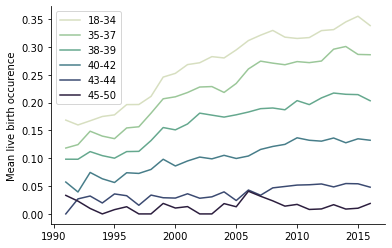

In [21]:
for age in age_groups:
    mask = df['Patient Age at Treatment']==age
    df.loc[df['Live Birth Occurrence'].isna(),'Live Birth Occurrence'] = 0
    lbr = df[mask].groupby('Year of Treatment')['Live Birth Occurrence'].mean()
    plt.plot(lbr, label = age)
plt.ylabel('Mean live birth occurence')
plt.legend()
ax = plt.gca()
utils.remove_axes(ax)
plt.savefig('images/lbr_by_age.png', dpi=300, bbox_inches='tight')

In [16]:
df.groupby('Live Birth Occurrence').count()

,Patient Age at Treatment,Date patient started trying to become pregnant OR date of last pregnancy,"Total Number of Previous cycles, Both IVF and DI","Total Number of Previous treatments, Both IVF and DI at clinic",Total Number of Previous IVF cycles,Total Number of Previous DI cycles,"Total number of previous pregnancies, Both IVF and DI",Total number of IVF pregnancies,Total number of DI pregnancies,Total number of live births - conceived through IVF or DI,...,Heart Three Sex,Heart Three Delivery Date,Heart Three Birth Congenital Abnormalities,Heart Four Weeks Gestation,Heart Four Birth Outcome,Heart Four Birth Weight,Heart Four Sex,Heart Four Delivery Date,Heart Four Birth Congenital Abnormalities,target
Live Birth Occurrence,,,,,,,,,,,,,,,,,,,,,
1.0,175766,54735,175766,175766,175766,175766,175766,175766,175766,175766,...,1739,1729,19,21,34,19,21,21,0,175744


In [630]:
df = pd.read_csv('data/ar-2015-2016.csv')

df = (df.pipe(format_columns)
        .pipe(create_cohort)
        .pipe(create_target)
        .pipe(drop_anomalous_cycles))

print(df.shape)

c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7,29,31,32,43,48,50,51,52,53,54,77,83,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(86169, 96)


In [9]:
age_groups = ['18-34', '35-37', '38-39', '40-42', '43-44', '45-50']

## 0.1 Number of patients in each class

In [476]:
df.groupby('target')['Patient Age at Treatment'].count()

target
0.0    37577
1.0    49875
Name: Patient Age at Treatment, dtype: int64

## 0.2 Number of patients in each age group

In [477]:
df.groupby('Patient Age at Treatment')['target'].count()

Patient Age at Treatment
18-34    37826
35-37    20154
38-39    12989
40-42    12242
43-44     3266
45-50      975
Name: target, dtype: int64

# 1 Initial data analysis

## 1.1 Number of eggs collected by age group

Outliers are not shown since the distributions have such long tails.

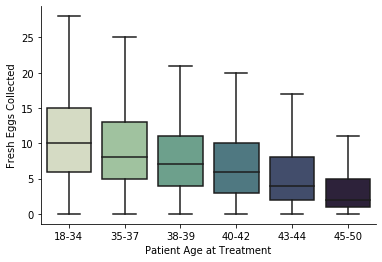

In [389]:
fig, ax = plt.subplots()
sns.boxplot(x='Patient Age at Treatment', y='Fresh Eggs Collected', ax=ax, data=df,
           order=age_groups, showfliers=False)

utils.remove_axes(ax)
plt.savefig('images/eggs_collected_by_age.png', dpi=300, bbox_inches='tight')

## 1.2 Proportion of patients with suitable embryos by Number eggs collected

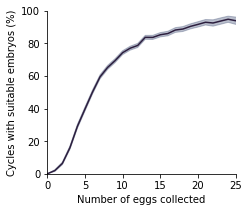

In [390]:
fig, ax = plt.subplots()

mean_embryos = df.groupby('Fresh Eggs Collected')['target'].mean()
count_embryos = df.groupby('Fresh Eggs Collected')['target'].count()
mean_error = 1.96 * ((mean_embryos.values * (1-mean_embryos.values)) / count_embryos.values) **0.5

# configure the plots 
x = mean_embryos.index
y = mean_embryos.values

ax.plot(x, y*100, color=colors[-1], lw=1.5)
ax.fill_between(x, (y-mean_error)*100, (y+mean_error)*100, color=colors[-2], alpha=0.35)
ax.set_xlim(0, 25)
ax.set_ylim(0, 100)

ax.set_ylabel('Cycles with suitable embryos (%)')
ax.set_xlabel('Number of eggs collected')

utils.remove_axes(ax)

fig.set_size_inches(3+3/8, 3)
plt.savefig('images/cycles_with_suitable_embryos.png', dpi=300, bbox_inches='tight')

### 1.2.1 Proportion of patients with suitable embryos by Number eggs collected and age

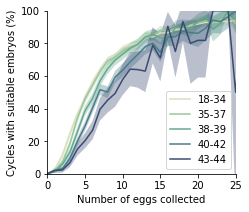

In [391]:
fig, ax = plt.subplots()

for age in age_groups[:-1]:
    mask = df['Patient Age at Treatment']==age
    mean_embryos = df[mask].groupby('Fresh Eggs Collected')['target'].mean()
    count_embryos = df[mask].groupby('Fresh Eggs Collected')['target'].count()
    mean_error = 1.96 * ((mean_embryos.values * (1-mean_embryos.values)) / count_embryos.values) **0.5
    
    # configure the plots 
    x = mean_embryos.index
    y = mean_embryos.values
    ax.plot(x, y*100, lw=1.5, label=age)
    ax.fill_between(x, (y-mean_error)*100, (y+mean_error)*100, alpha=0.35)
ax.legend()
ax.set_xlim(0, 25)
ax.set_ylim(0, 100)

ax.set_ylabel('Cycles with suitable embryos (%)')
ax.set_xlabel('Number of eggs collected')

utils.remove_axes(ax)

fig.set_size_inches(3+3/8, 3)
plt.savefig('images/cycles_with_suitable_embryos_by_age.png', dpi=300, bbox_inches='tight')

## 1.3 Proportion of patients with suitable embryos by age group

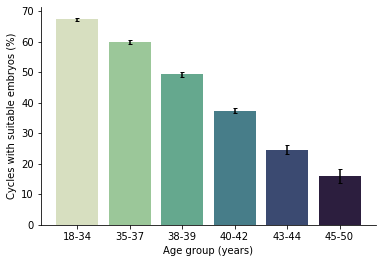

In [527]:
age_grouping = df.groupby('Patient Age at Treatment')['target'].agg(['mean', 'count'])


x = age_grouping.index
y = age_grouping['mean'].values
c = age_grouping['count'].values

errors  =  1.96 *  ((y * (1-y)) / c) **0.5

# plot the figure

fig, ax = plt.subplots()

ax.bar(np.arange(0,len(y)), y*100, yerr=errors*100, capsize=2, color=colors)
ax.set_ylabel('Cycles with suitable embryos (%)')
utils.remove_axes(ax)

# set the xtick labels
ax.set_xticklabels([''] + age_groups)
ax.set_xlabel('Age group (years)')
plt.savefig('images/cycles_with_embryos_by_age_group.png', dpi=300, bbox_inches='tight')

## 1.4 Proportion of patients with suitable embryos by infertility diagnosis

In [399]:
infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]

c:\users\fpc\envs\ivf\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\fpc\envs\ivf\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


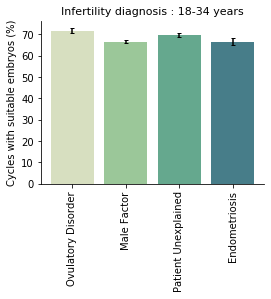

In [456]:
means = []
errors = []

age='18-34'

for col in infertility_columns:
    mask = (df[col]==1) & (df['Patient Age at Treatment']==age)
    infertility_target = df.loc[mask, 'target'].values
    mean_embryos = np.mean(infertility_target)
    count_embryos = len(infertility_target)
    error = 1.96 *  ((mean_embryos * (1-mean_embryos)) / count_embryos) **0.5
    means.append(mean_embryos)
    errors.append(error)
    
# make the figure
xlabels = [col.replace('Cause of Infertility - ', '') for col in infertility_columns]


fig, ax = plt.subplots()
ax.bar(xlabels[:4], np.array(means[:4])*100, yerr=np.array(errors[:4])*100, capsize=2, color=colors[:4])
utils.remove_axes(ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title('Infertility diagnosis : {} years'.format(age), fontsize=11)
ax.set_ylabel('Cycles with suitable embryos (%)')
fig.set_size_inches(4,3)

plt.savefig('images/cycles_with_embryos_by_infertility_diagnosis_{}.png'.format(age), dpi=300, bbox_inches='tight')

## 1.5 By Type of treatment

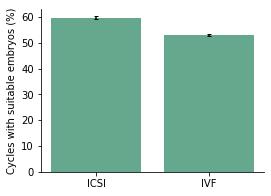

In [498]:
treatment_types = df.groupby('Specific treatment type')['target'].agg(['mean','count'])

x = treatment_types.index
y = treatment_types['mean'].values
c = treatment_types['count'].values

errors  =  1.96 *  ((y * (1-y)) / c) **0.5

# plot the figure

fig, ax = plt.subplots()

ax.bar(x, y*100, yerr=errors*100, color=colors[-4], capsize=2)
ax.set_ylabel('Cycles with suitable embryos (%)')
utils.remove_axes(ax)

fig.set_size_inches(4,3)
plt.savefig('images/cycles_with_embryos_by_type_of_treatment.png', dpi=300, bbox_inches='tight')

# 2.0 Modelling

 - To do : create hold-out test set (stratified by age group) of 20 % of cycles X, Xt, y, yt
 - Five-fold cross validation on remaining training set
 - Bootstap of errors
 - Train several models:
     - Logistic regression
     - Random forest
 
 - Optional : SHAP of features.

In [631]:
def create_training_test(df, features=None, seed=123, test_size=0.2):
    """
    Creates the training and test set for modelling. The training and test
    set are stratified by age.
    
    Parameters:
    -----------
    df : pd.DataFrame, 
        The HFEA IVF dataset.
    
    features : List[str] (default=None),
        List of features (columns) to include in the training/test sets.
        If None 4 features are usef.
    
    seed : int (default=123), 
        Random seed for the split.
    
    test_size : float, 
        Size of the hold-out test.
    
    Returns:
    --------
    X : np.array,
        Training set.
    
    Xt : np.array,
        Hold-out test set.
    
    y : np.array, 
        Target for the training set.
    
    yt : np.array,
        Target for the hold-out test set.
    """
    if features is None:
        infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]
        features = (['Patient Age at Treatment', 'Fresh Eggs Collected', 'Specific treatment type'] +
                    infertility_columns[:4])
        
    data = df[features].values
    target = df['target'].values
    groups = df['Patient Age at Treatment']
    return train_test_split(data, target, stratify=groups, test_size=test_size, random_state=seed)



In [636]:
def fit_model(X, y, model=XGBClassifier, params={}, uid=None,
              cv_splitter=StratifiedKFold, nsplits=5):
    """
    Fits a model using given params and CV method and returns the fitted 
    classifier. If multiple-fold cross-validation is used each individual 
    classifier is returned within an iterable
    
    Parameters:
    -----------
    X : np.array,
        Training data shape (n,m) where n is the number of instances and m the number of 
        features.
        
    y : np.array,
        Labels for training data, shape (n,).
    
    model : sklearn.base.BaseEstimater (default=XGBClassifier),
        The classifier to fit. Must be compatible with the sklearn API.
    
    params : dict,
        Parameter dictionary to be passed to the model.
    
    uid : np.array (default=None),
        User ids for each training instance, shape (n,). This is passed to the 
        cv_splitter so (for example) patient-wise validation folds can be 
        created.
    
    cv_splitter : cross-validation generator, 
        The cross-validation splitter (consitent with sklearn API)
        
    nsplits : int,
        The number of validation folds to create. Passed to cv_splitter.
        
    Returns:
    --------
    models, sklearn.base.BaseEstimater 
        Returns the fitted model(s)instance.
    """
    
    splitter = cv_splitter(n_splits=nsplits)
    
    oof_preds = np.zeros(len(X))
    models = []
    for train_index, test_index in splitter.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model(**params)
        clf.fit(X_train, y_train)
        models.append(clf)
        oof_preds[test_index] = clf.predict_proba(X_test)[:,1]
    oof_score = roc_auc_score(y, oof_preds)
    return models, oof_score

In [633]:
df = encode_columns(df)

In [634]:
X, Xt, y, yt = create_training_test(df)

## 2.1 Model 1

Uses only one features
    - Patient Age

In [624]:
infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]
features = ['Patient Age at Treatment','Fresh Eggs Collected', 'Specific treatment type',infertility_columns[:4]]

In [638]:
# perform boot strapping for errors 
for feature in features:
    X, Xt, y, yt = create_training_test(df, features=feature)
    ncycles = 100
    scores = np.zeros(ncycles)
    for i in range(ncycles):
        bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
        X_bs = X[bs_idx]
        y_bs = y[bs_idx]
        # if only one feature add additional dimension
        try:
            X_bs.shape[1]
        except:
            X_bs = X_bs.reshape((-1,1))
            Xt = Xt.reshape((-1,1))
        models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
        scores[i] = score
    confidence = utils.confidence_intervals(scores)
    print('----*----')
    print(feature)
    print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
Patient Age at Treatment
AUROC: 0.635 CI: 0.631-0.639
----*----
Fresh Eggs Collected
AUROC: 0.838 CI: 0.835-0.841
----*----
Specific treatment type
AUROC: 0.533 CI: 0.530-0.536
----*----
['Cause of Infertility - Ovulatory Disorder', 'Cause of Infertility - Male Factor', 'Cause of Infertility - Patient Unexplained', 'Cause of Infertility - Endometriosis']
AUROC: 0.549 CI: 0.545-0.552


### 2.1.1 Model 1.1

Age and number of eggs


In [690]:
features = ['Patient Age at Treatment','Fresh Eggs Collected']

In [697]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.843 CI: 0.840-0.846


In [692]:
models, score = fit_model(X, y, cv_splitter=KFold)

In [696]:
np.save('results/HFEA_model_age_number_eggs.npy', models)

### 2.1.2  Model 1.2

In [641]:
features = ['Patient Age at Treatment','Fresh Eggs Collected', 'Specific treatment type']

In [642]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.844 CI: 0.842-0.847


### 2.1.3 Model 1.3

In [643]:
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + infertility_columns[:4]

In [644]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.845 CI: 0.842-0.848


### 2.14 Model 1.4

In [645]:
features = ['Patient Age at Treatment','Fresh Eggs Collected', 'Specific treatment type'] + infertility_columns[:4]

In [646]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.845 CI: 0.842-0.848


# 3. Model hyperparameter tuning

In [648]:
def tune_model(X, y, param_grid, uid=None, model=XGBClassifier, 
               cv_splitter=KFold, n_splits=5, metric='roc_auc'):
    """Tunes hyperparameters of a model by performing cross-validated grid_search.
    
    Parameters:
    -----------
    X : np.array, 
        Training data shape (n,m) where n is the number of instances and m the
        number of features.
        
    y : np.array,
        Labels for training data, shape (n,).
    
    param_grid : dict, 
        Parameter dictionary to be passed to the model. Each value should be a 
        list of values of the specified parameter to search.
            
    model : sklearn.Base.BaseEstimater (default=XGBClassifier),
        The classifier to fit. Must be compatible with the sklearn API.
        
    cv_splitter : cross-validation generator (default=GroupKFold),
        The cross-validation splitter (consitent with sklearn API).
    
    nsplits : int,
        The number of validation folds to create. Passed to cv_splitter.
        
    Returns
    --------
    clf : GridSearchCV,
        A fitted instance of a GridSearchCV class.
        
    """
    # instantiate model
    model = XGBClassifier()
    # get training / validation fold idxs
    cv_splits = None
    if cv_splitter is not None:
        cv_splitter = cv_splitter(n_splits=n_splits)
        cv_splits = []
        for train_index, test_index in cv_splitter.split(X, y):
            cv_splits.append((train_index, test_index))
    hyperparameter = GridSearchCV(estimator=model, param_grid=param_grid, 
                                  scoring=metric, cv=cv_splits)
    hyperparameter.fit(X, y)
    
    return hyperparameter

In [649]:
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + infertility_columns[:4]

In [651]:
param_grid =  {'max_depth':[2,3,4],'subsample':[1,0.9, 0.8], 'gamma':[1,5,10,25], 'learning_rate':[0.05,0.025,0.1], 'n_estimators':[75,100, 125]}

In [655]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)

hyperparameters = tune_model(X, y, param_grid=param_grid)

In [657]:
hyperparameters.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [661]:
np.save('results/y_true_xgboost.npy', yt)

In [668]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 250
scores = np.zeros(ncycles)
yt_preds_list = []
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold, params=hyperparameters.best_params_)
    yt_preds = np.zeros(len(Xt))
    for model in models:
        yt_preds += model.predict_proba(Xt)[:,1]/len(models)
    scores[i] = roc_auc_score(yt, yt_preds)
    yt_preds_list.append(yt_preds)
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

np.save('results/y_preds_xgboost.npy', yt_preds_list)

----*----
AUROC: 0.841 CI: 0.840-0.841


## 3.1 Evaluation of model

In [674]:
bs_preds = np.load('results/y_preds_xgboost.npy')

In [676]:
mean_preds = np.mean(bs_preds, axis=0)
fpr, tpr, _ = roc_curve(yt, mean_preds)

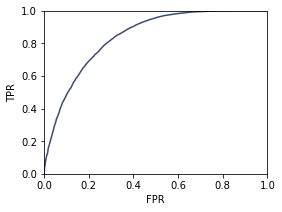

In [682]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color=colors[-2])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

fig.set_size_inches(4,3)
plt.savefig('images/HFEA_model_evaluation_ROC.png', dpi=300, bbox_inches='tight')

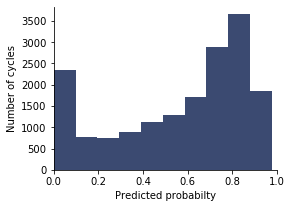

In [689]:
fig, ax = plt.subplots()

ax.hist(mean_preds, color=colors[-2])
ax.set_xlabel('Predicted probabilty')
ax.set_ylabel('Number of cycles')
ax.set_xlim(0,1)
utils.remove_axes(ax)

fig.set_size_inches(4,3)
plt.savefig('images/HFEA_model_predictions.png', dpi=300, bbox_inches='tight')